In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Input_path='/kaggle/input/emg-signal-channel-8/emg-signal.csv'

/kaggle/input/emg-signal-channel-6/emg-signal.csv
/kaggle/input/emg-signal-channel-5/emg-signal.csv
/kaggle/input/emg-signal-channel-2/emg-signal.csv
/kaggle/input/emg-signal-1/emg-signal.csv
/kaggle/input/emg-signal-channel-1/emg-signal.csv
/kaggle/input/emg-signal-channel-4/emg-signal.csv
/kaggle/input/emg-signal-channel-7/emg-signal.csv
/kaggle/input/emg-signal-for-gesture-recognition/EMG-data.csv
/kaggle/input/emg-signal-channel-8/emg-signal.csv


In [36]:
dataset=pd.read_csv(Input_path)
print(dataset.shape)
##check for any null/empty values
print("\nempty values:",dataset.isnull().any().sum()) 

(999998, 4)

empty values: 0


In [37]:
dataset=dataset.drop(columns=["time"])
Class = dataset["class"]
print(Class.unique())
print("Value Count :\n", dataset["class"].value_counts())

[0 1 2 3 4 5 6]
Value Count :
 0    652010
6     58738
4     58441
5     58290
3     58076
1     57873
2     56570
Name: class, dtype: int64


In [38]:
##drop gesture 0 because it offers no information due to its unmarked nature
index_numbers_1=dataset[dataset["class"]==0].index 
dataset.drop(index_numbers_1,inplace=True)

##drop gesture 7 because it offers no information due to it being performed 
##by just two out of 36 patients 
index_numbers_2=dataset[dataset["class"]==5].index 
dataset.drop(index_numbers_2,inplace=True)
index_numbers_2=dataset[dataset["class"]==6].index
dataset.drop(index_numbers_2,inplace=True)

In [39]:
dataset=dataset.groupby(['label','class'])

In [40]:
##functions for extracting sEMG features
def rms(data): ##root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def SSI(data): ##Simple Square Integral
    return np.sum(data**2,axis=0)

def abs_diffs_signal(data): ##absolute differential signal
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

##function for returning an estimator class name 
def print_estimator_name(estimator):
    return estimator.__class__.__name__

In [41]:
##tabulating the aggregated sEMG features
dataset=dataset.agg(['min','max',rms,SSI,abs_diffs_signal,np.ptp])

In [42]:
dataset=dataset.reset_index()
dataset.head()

label class channel8                                                       
                   min      max       rms       SSI abs_diffs_signal      ptp
0     1     1 -0.00005  0.00002  0.000014  0.000001          0.00921  0.00007
1     1     2 -0.00070  0.00054  0.000150  0.000153          0.11696  0.00124
2     1     3 -0.00073  0.00051  0.000161  0.000190          0.11869  0.00124
3     1     4 -0.00032  0.00026  0.000083  0.000047          0.04984  0.00058
4     2     1 -0.00005  0.00004  0.000015  0.000002          0.01048  0.00009

In [43]:
temp2=dataset

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


25 11
0.2222222222222222
[[1 0 0 0]
 [2 0 1 0]
 [1 0 2 0]
 [4 0 0 0]]
0.2727272727272727


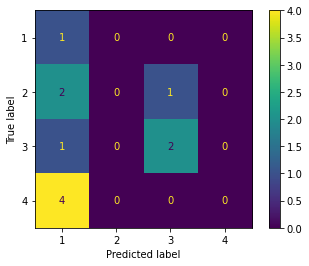

In [44]:
## Training SVM Classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
estimators=[]
accuracy=[]
f1_macro=[]
svc=SVC(C=100,kernel='poly',gamma=0.01,decision_function_shape='ovo')
features=dataset.drop(columns=["label","class"])
labels=dataset["class"]
##Training and testing set splitting
X_train, X_test,y_train,y_test= train_test_split(features,labels,test_size=0.30, random_state=1)
print(len(X_train), len(X_test))
## Data normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std
X_test -= mean
X_test /= std
svc.fit(X_train,y_train)
y_test_pred=svc.predict(X_test)
y=f1_score(y_test,y_test_pred,average='macro') 
x=confusion_matrix(y_test,y_test_pred)
a=accuracy_score(y_test,y_test_pred)
print(y)
print(x)
print(a)
estimators.append(print_estimator_name(svc))
f1_macro.append(y)
accuracy.append(a)
plot_confusion_matrix(svc,X_test,y_test)
plt.show()


In [45]:
estimators

['SVC']

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


F1_macro= 0.7517857142857143
[[1 0 0 0]
 [0 1 1 1]
 [0 0 3 0]
 [0 1 0 3]]
Accuracy= 0.7272727272727273
OOB validation score= 0.64


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=[1 2 3 4 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


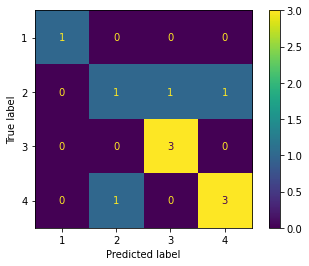

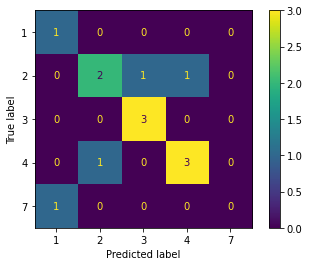

In [46]:
## Training Random Forest classifier
from sklearn.metrics import ConfusionMatrixDisplay
dataset=temp2
rfc=RandomForestClassifier(criterion= 'entropy', max_depth= 50, max_features= 5, max_leaf_nodes= 50,min_samples_split=2,n_estimators=2000,oob_score=True)
features=dataset.drop(columns=["label","class"])
labels=dataset["class"]
X_train, X_test,y_train,y_test= train_test_split(features,labels,test_size=0.30, random_state=1)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std
X_test -= mean
X_test /= std
rfc.fit(X_train,y_train)
y_test_pred=rfc.predict(X_test)
y=f1_score(y_test,y_test_pred,average='macro') 
x=confusion_matrix(y_test,y_test_pred)
a=accuracy_score(y_test,y_test_pred)
print('F1_macro=',y)
print(x)
print('Accuracy=',a)
print('OOB validation score=',rfc.oob_score_)
estimators.append(print_estimator_name(rfc))
f1_macro.append(y)
accuracy.append(a)
plot_confusion_matrix(rfc,X_test,y_test)

#########
x=np.array([[1,0,0,0,0], [0,2,1,1,0], [0,0,3,0,0], [0,1,0,3,0], [1,0,0,0,0]])
labels=np.array([1,2,3,4,7])
disp = ConfusionMatrixDisplay(x, labels)
disp.plot()
#########


plt.show()

In [47]:
estimators

['SVC', 'RandomForestClassifier']

In [48]:
for i in np.arange(len(estimators)):
    f1_macro[i]=round(f1_macro[i],3)
    accuracy[i]=round(accuracy[i],3)

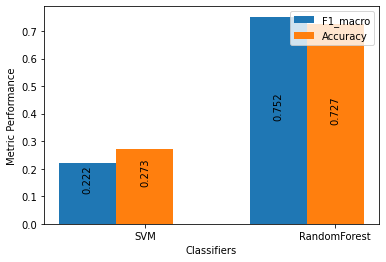

In [49]:
## plotting results of comparative study
estimators=['SVM','RandomForest']
fig, ax = plt.subplots()
width=0.3
bar_plot1 = ax.bar(np.arange(len(estimators)),f1_macro,width,tick_label=estimators)
bar_plot2 = ax.bar(np.arange(len(estimators))+width,accuracy,width,tick_label=estimators)

ax.set_xlabel('Classifiers')
ax.set_ylabel('Metric Performance')
ax.legend(('F1_macro','Accuracy'),loc='upper right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,height,ha='center', va='bottom', rotation=90)
autolabel(bar_plot1)
autolabel(bar_plot2)
plt.show()